## API sobre datos de transporte

En este ejemplo vamos a conectarnos con una [API Transporte](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte) del Gobierno de la Ciudad que nos da información del transporte, como por ejemplo estado del trańsito y estado actual del subte. 

Este tipo de APIs son quizás las más aprovechables a la hora de pensar en desarrollar una aplicación, dado que los datos no son estáticos sino que se van actualizando a cada momento. Piensen en servicios que reciben la ubicación de los colectivos y devuelve esa información volcada en un mapa, o bien que calcule el tiempo de recorrido dado el estado del tránsito en tiempo real. Estos datos combinados con las herramientas y modelos vistos en la materia le dan un valor más que interesante.

Para usar esta API tienen que registrarse [aquí](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte), con lo cual obtienen las claves *client_id* y *client_secret* que en este caso (según la documentación) se pasan como parámetros en cada request.

#### Módulos 

In [1]:
# Cargamos en memoria los modulos necesarios
import pandas as pd
import matplotlib.pyplot as plt 
from pandas.io.json import json_normalize
import geopandas as gpd
import altair as alt
# Importamos la librería requests y json para formatear la salida

import requests
import json
# Solamente hace falta client_id y client_secret
# Se sacan registrandose en 
# https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte

client_id = "18b8b37c9d5f4e39a5dd0f41ba5c925f"
client_secret = "77F1e9f202eC4cEDb106191f62Ac7e92"

# Estas claves van a ser borradas proximamente, generar sus propias claves

#### Función para cargar información conectándose a la API 

In [2]:
def load_data(topic):
    # Token
    client_id = "18b8b37c9d5f4e39a5dd0f41ba5c925f"
    client_secret = "77F1e9f202eC4cEDb106191f62Ac7e92"
    
    # json y agency_id solo son requeridos para buses, pero si lo pasamos en el resto de los topic,
    # funciona sin problema.
    params = {'client_id': client_id, 'client_secret': client_secret, 'json': 1, 'agency_id': 2}
    
    # URL
    url = "https://apitransporte.buenosaires.gob.ar"
    
    # dict con cada end_point y columna para procesar según topic
    dict_topic ={
      'stations_st': {'end_point':'/ecobici/gbfs/stationStatus',
                      'columns':'data',
                     'params':''},
      'stations_inf': {'end_point':'/ecobici/gbfs/stationInformation',
                      'columns':'data',
                      'params':''},
      'incidents': {'end_point':'/transito/v1/cortes',
                      'columns':'incidents',
                      'params':''},
      'buses': {'end_point':'/colectivos/vehiclePositions',
                'columns':'_vehicle'
               }
    } 
    
    if (topic in list(dict_topic.keys())):
        
        url_to_get = url + dict_topic[topic]['end_point']
        response = requests.get(url_to_get, params = params)
        json_data = response.json()
        
        if topic == 'buses':
            df = pd.DataFrame(json_data['_entity'])
        
        else:
            df = pd.read_json(json.dumps(json_data))

        df = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df[dict_topic[topic]['columns']]],ignore_index=True)
    
    else:
    
        print('ERROR: No existe ese topic')
        return
     
    return df

## Ejemplos de uso

La forma general de comunicarse con esta API es la siguiente: 
~~~
"https://apitransporte.buenosaires.gob.ar" + end_point 
~~~
donde *end_point* los pueden tomar de la [documentación](https://www.buenosaires.gob.ar/desarrollourbano/transporte/apitransporte/api-doc).

Todos los parámetros que necesiten (además de que siempre vamos a tener que pasarle las claves) van al diccionario de parámetros.

### Posición de colectivos monitoreados

In [3]:
bus = load_data('buses')

###### Ejemplo de utilización de estos datos:

In [4]:
# Datos de los límites de diferentes municipios del país levantados con geopandas
# Cuando marquemos los buses, sólo se verá capital, que es por donde circulan.
# De todas formas, se podría filtrar como con cualquier dataframe.
data_muni = gpd.read_file('shape/comunas/comunas_wgs84.shp')

In [5]:
bus.rename(columns = {'_position._longitude': 'lon', 
                      '_position._latitude': 'lat', 
                     }, 
                inplace = True)

#### Altair 

In [6]:
points = alt.Chart(bus).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    tooltip=['_congestion_level'],
)

caba = alt.Chart(data_muni).mark_geoshape(stroke='white',
                            fill='lightgray').encode().properties(width=800,
                                                                 height=800).project('mercator')

caba+points

alt.LayerChart(...)

#### Pandas 

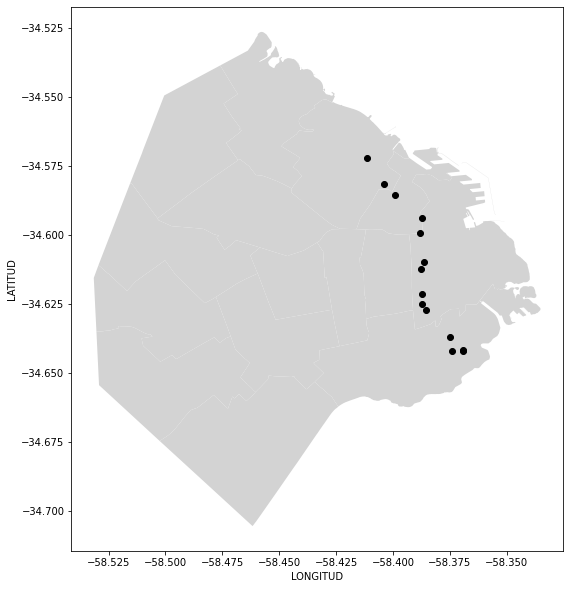

In [7]:
# Creamos la figura con matplotlib
fig, ax = plt.subplots(figsize = (10, 10))

# Ploteamos el shape cargado anteriormente. Es todo el país, pero sólo se verá CABA
data_muni.plot(ax=ax, color='lightgrey')
# La posición de los colectivos
x = bus['lon']
y = bus['lat']
ax.scatter(x, y, color = 'k')

# Labels de los ejes
ax.set_xlabel('LONGITUD') 
ax.set_ylabel('LATITUD');

### Estado de estaciones de EcoBici

In [8]:
# Cargamos la info de las estaciones: status e information

stations_inf = load_data('stations_inf')
stations_st = load_data('stations_st')

#### Merge 

In [9]:
stations = pd.merge(stations_inf,
                    stations_st,
                    how='left')

#### Alternativa 1: Geopandas 

In [10]:
gdf = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations.lon, stations.lat))
gdf.crs = {"init": "EPSG:4326"}
gdf = gdf.to_crs(epsg = 5343)

/home/mato/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [11]:
data_muni.crs = {"init": "EPSG:4326"}
data_muni = data_muni.to_crs(epsg = 5343)

/home/mato/.local/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


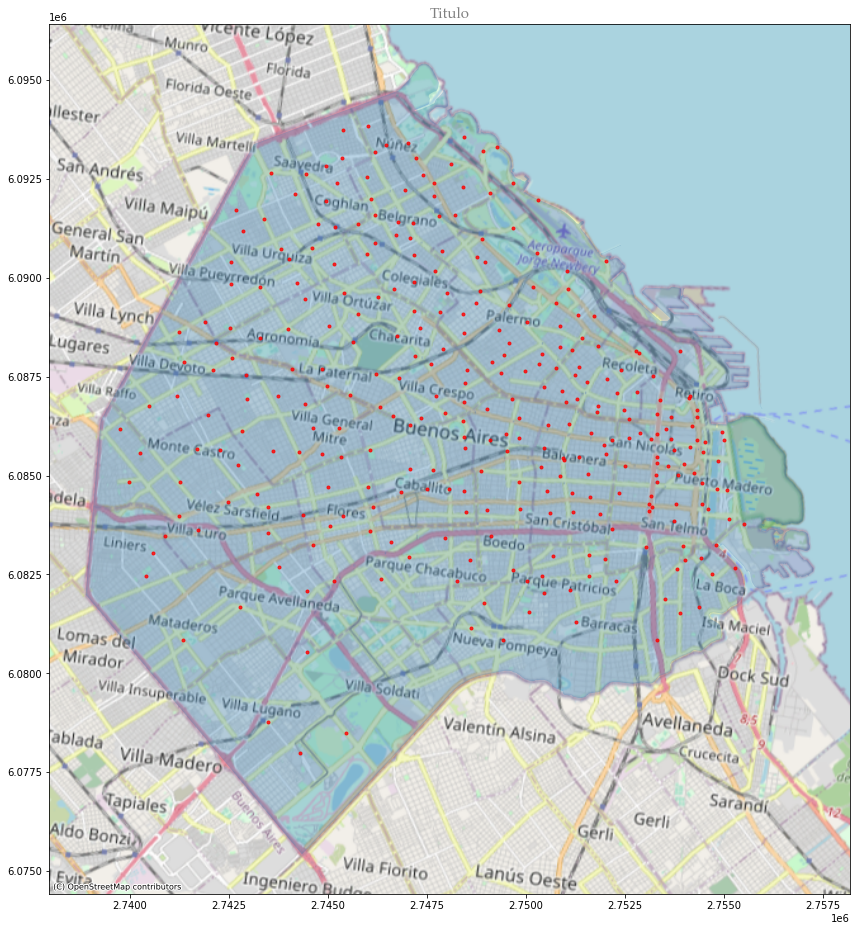

In [13]:
import contextily as ctx

fig, ax = plt.subplots(figsize=(16,16))
data_muni.plot(ax=ax, alpha = 0.3)
gdf.plot(ax=ax, color = 'red', marker = '.', alpha=0.8)
ctx.add_basemap(ax, crs='epsg:5343',source=ctx.providers.OpenStreetMap.Mapnik)

plt.title('Titulo', fontsize=15, fontname='Palatino Linotype', color='grey')
plt.show()

#### Alternativa 2: Altair

In [14]:
stations_st.head()

,station_id,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,last_reported,is_charging_station,status,is_installed,is_renting,is_returning,traffic,num_bikes_available_types.mechanical,num_bikes_available_types.ebike
0,2,19,0,1,0,1657462599,False,IN_SERVICE,1,1,1,None,19,0
1,3,10,0,10,0,1657462773,False,IN_SERVICE,1,1,1,None,10,0
2,4,18,0,2,0,1657462669,False,IN_SERVICE,1,1,1,None,18,0
3,5,9,1,32,0,1657462539,False,IN_SERVICE,1,1,1,None,9,0
4,6,4,2,14,0,1657462738,False,IN_SERVICE,1,1,1,None,4,0


In [15]:
import altair as alt

In [16]:
# Error comun en altair:
# Altair uses Data Transformers and requires all the columns to be “JSON Serializable”.
# This means that you should not have a geometric data type among your columns.
# Por eso, borramos la columna geometry
stations = stations[['station_id', 'name', 'physical_configuration', 'lat', 'lon',
       'altitude', 'address', 'post_code', 'capacity', 'is_charging_station',
       'rental_methods', 'groups', 'obcn', 'nearby_distance', 'cross_street',
       'num_bikes_available', 'num_bikes_disabled', 'num_docks_available',
       'num_docks_disabled', 'last_reported', 'status', 'is_installed',
       'is_renting', 'is_returning', 'traffic',
       'num_bikes_available_types.mechanical',
       'num_bikes_available_types.ebike']]

In [17]:
# !pip3 install contextily


In [18]:
points = alt.Chart(stations).mark_circle().encode(
    longitude='lon:Q',
    latitude='lat:Q',
    size=alt.value(80),
    color='num_bikes_available',
    tooltip=['name','address','num_bikes_available', 'num_bikes_disabled', 'num_docks_available','last_reported'],
).properties(
    width=500,
    height=400
)

data_muni = gpd.read_file('shape/comunas/comunas_wgs84.shp')

caba = alt.Chart(data_muni).mark_geoshape(stroke='white',
                            fill='lightgray').encode().properties(width=800,
                                                                 height=800).project('mercator')
mapa = caba + points
mapa

alt.LayerChart(...)

### Cortes de tránsito

In [19]:
incidents = load_data('incidents')

In [20]:
incidents

,id,parent_event,type,description,reference,creationtime,updatetime,starttime,endtime
0,batransito-2208620-Closure-3393,batransito-2208620,ROAD_CLOSED,Corte Por Obra (batransito),batransito,2021-07-05T11:53:02-03:00,2021-07-05T14:06:46-03:00,2021-07-05T11:51:53-03:00,2021-07-06T11:51:53-03:00
1,batransito-2208620-Closure-3394,batransito-2208620,ROAD_CLOSED,Corte Por Obra (batransito),batransito,2021-07-05T11:53:02-03:00,2021-07-05T14:06:46-03:00,2021-07-05T11:51:53-03:00,2021-07-06T11:51:53-03:00
2,batransito-2206458-Closure-2741,batransito-2206458,ROAD_CLOSED,Buenos Aires: en Área Buenos Aires en AV. RIE...,batransito,2021-04-15T15:40:54-03:00,2021-04-15T21:46:08-03:00,2021-04-15T15:40:05-03:00,2021-04-16T15:40:05-03:00
3,batransito-2206458-Closure-2742,batransito-2206458,ROAD_CLOSED,Buenos Aires: en Área Buenos Aires en AV. RIE...,batransito,2021-04-15T15:40:54-03:00,2021-04-15T21:46:08-03:00,2021-04-15T15:40:05-03:00,2021-04-16T15:40:05-03:00
4,batransito-2211615-Closure-4212,batransito-2211615,ROAD_CLOSED,Buenos Aires: en Área Buenos Aires en AV.GRAL...,batransito,2021-10-14T11:43:49-03:00,2021-10-14T17:54:56-03:00,2021-10-14T11:42:36-03:00,2021-10-15T11:42:36-03:00
5,batransito-2212834,NaN,ACCIDENT,INCIDENTE VIAL (batransito),batransito,2021-11-17T06:57:29-03:00,2021-11-17T07:00:57-03:00,2021-11-17T06:56:32-03:00,2021-11-18T06:56:32-03:00


### Carga de datos sin función

#### Buses

In [46]:
# Claves como parametros, mas los parametros propios de cada endpoint
# Aquí tenemos que pedirle explícitamente que nos devuelva los datos en json
params = {'client_id': client_id, 'client_secret': client_secret, 'json': 1, 'agency_id': 2}

# Url y end point (lo vemos siempre en la documentación)
url = "https://apitransporte.buenosaires.gob.ar"
end_point = "/colectivos/vehiclePositions"

# Método get
response = requests.get(url + end_point, params = params)

# Respuesta en formato json
json_data = response.json()
# Llamamos a dumps para que la salida sea más fácil de leer 
# print(json.dumps(json_data, indent = 4))

# bus=pd.read_json(json.dumps(json_data['_vehicle']))
bus = pd.DataFrame(json_data['_entity'])

# Abrimos el campo data, que es otro json, pero tiene la info que nos interesa.
bus = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in bus['_vehicle']],ignore_index=True)

#### Incidentes (idem a stationsstatus y stationsinformation) 

In [460]:
# # Claves como parametros, mas los parametros propios de cada endpoint
# params = {'client_id': client_id, 'client_secret': client_secret}

# # Url y end point (lo vemos siempre en la documentación)
# url = "https://apitransporte.buenosaires.gob.ar"
# end_point = "/transito/v1/cortes"

# # Método get
# response = requests.get(url + end_point, params = params)

# # Respuesta en formato json
# json_data = response.json()

# # Llamamos a dumps para que la salida sea más fácil de leer 
# # print(json.dumps(json_data, indent = 4))